# SARIMA Model for Forecasting Bitcoin Transaction Fees (Next 24 Hours)

This notebook builds and evaluates a SARIMA model to forecast the **Bitcoin transaction fee** over the **next 24 hours**. 

### Why SARIMA?

During exploratory data analysis (EDA), we identified:
- **Daily seasonality patterns** in transaction fees (24-hour cycle),
- **Strong autocorrelation**, indicating temporal dependence.

Given these findings, the SARIMA model is an appropriate choice as it can model:
- Autoregressive and moving average components,
- Differencing for trend removal,
- **Seasonal effects**, such as daily cyclic behavior.

This notebook walks through the full modeling pipeline using SARIMA.


In [1]:
from sktime.forecasting.model_selection import (ExpandingWindowSplitter, temporal_train_test_split)
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import AutoARIMA, ARIMA
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_squared_error
from sktime.forecasting.model_evaluation import evaluate
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

## 1. Data Loading

We begin by loading the preprocessed dataset specifically prepared for SARIMA and HWES models.


In [2]:
df = pd.read_parquet('../data/processed/preprocessed_sarima_hwes.parquet')

df.head()


,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,mempool_fee_histogram_bin_70_75,mempool_fee_histogram_bin_75_80,mempool_fee_histogram_bin_80_85,mempool_fee_histogram_bin_85_90,mempool_fee_histogram_bin_90_95,mempool_fee_histogram_bin_95_100,mempool_fee_histogram_bin_100_150,mempool_fee_histogram_bin_150_200,mempool_fee_histogram_bin_200_250,mempool_fee_histogram_bin_250_300
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-05 02:10:00,2131827.0,997874.25,1030.0,2077770.0,1.300139,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:15:00,1986259.0,997882.00,1915.0,2663152.0,2.000000,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:20:00,1814202.0,997958.25,2710.0,3423846.0,2.413300,3.0,3.0,3.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:25:00,1604116.0,997937.50,3256.0,4136741.0,3.008581,4.0,3.0,3.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:30:00,2200654.0,997987.75,1015.0,1890732.0,1.362632,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 2. Autocorrelation, Partial Autocorrelation Analysis and Stationarity Check (ADF Test)

To determine the appropriate AR (autoregressive) and MA (moving average) orders, we examine the **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** of the target variable. Before fitting a SARIMA model, we need to verify if the time series is **stationary** — a key assumption for ARIMA-family models. We use the **Augmented Dickey-Fuller (ADF) test**, which tests the null hypothesis that the time series has a unit root (i.e., is non-stationary).

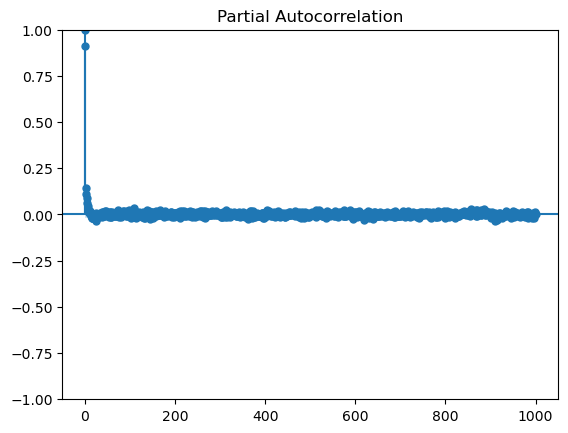

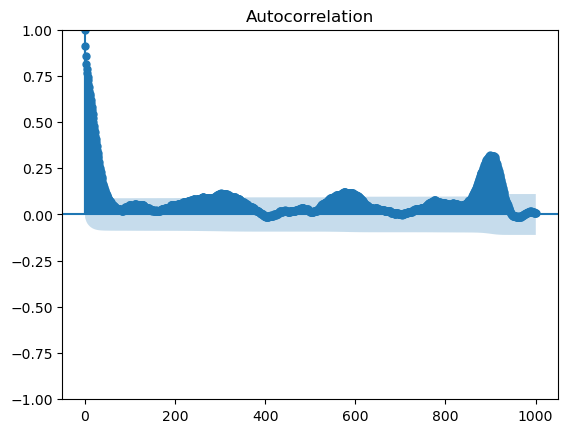

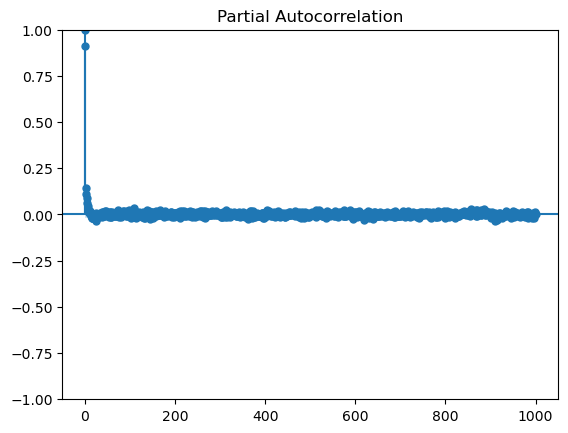

In [3]:
y = df["recommended_fee_fastestFee"]
plot_acf(y, lags=1000)   
plot_pacf(y, lags=1000)

In [4]:
adfuller(y)[1]

np.float64(1.0896816913186839e-24)

The PACF cuts off at lag 1 and the ACF shows a significant lag-1 with slow decay, suggesting an ARIMA(1, 0, 1) structure. Clear seasonal spikes at lag 288 in the ACF indicate a seasonal pattern, so we set the seasonal order to (1, 0, 1, 288)

## 3. Sampling and Splitting (Last 7 Days)

To reduce computational cost, we focus on the **most recent 7 days**

In [5]:
#sample 7 days data due to computational resource

end_date = y.index.max()
start_date = end_date - pd.Timedelta(days=7)
y_month = y.loc[start_date:end_date]
y_train, y_test = temporal_train_test_split(y_month, test_size=288)
# Log-transform training data to stabilize variance and for outliers
y_train_log = np.log1p(y_train)

y_train.shape

(1729,)

## 4. Define Forecast Horizon and Fit SARIMA Model

We now initialize the SARIMA model and fit it on the log-transformed training data.

In [6]:
fh = ForecastingHorizon(y_test.index, is_relative=False)

In [7]:
# desired_folds = 5
# total_len = len(y)
# fh_max = 288

# step_length = (total_len - 6000 - fh_max) // (desired_folds - 1)
# cv = ExpandingWindowSplitter(
#     initial_window=6000,
#     fh=fh,
#     step_length=step_length 
# )

In [8]:
forecaster = ARIMA(
    order=(1, 0, 1),                
    seasonal_order=(1, 0, 1, 288)  
)

In [9]:
forecaster.fit(y_train_log)

/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(order=(1, 0, 1), seasonal_order=(1, 0, 1, 288))

In [10]:
# results = evaluate(
#     forecaster=forecaster,
#     y=y,
#     cv=cv,
#     strategy="update",
#     scoring=[mean_squared_error, mean_absolute_percentage_error],
#     return_data=True
# )

# 5. Forecasting and Evaluation

After fitting the SARIMA model, we generate forecasts and evaluate performance using RMSE and MAPE.


In [13]:
y_pred_log = forecaster.predict(fh)
y_pred = np.expm1(y_pred_log)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE on 24h test set: {rmse:.4f}")
mae = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE on 24h test set: {mae:.4f}")

RMSE on 24h test set: 2.0329
MAPE on 24h test set: 0.5352


/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# 6. Forecast Visualization

We visualize the SARIMA model’s forecast against the actual log-transformed values over the test period.

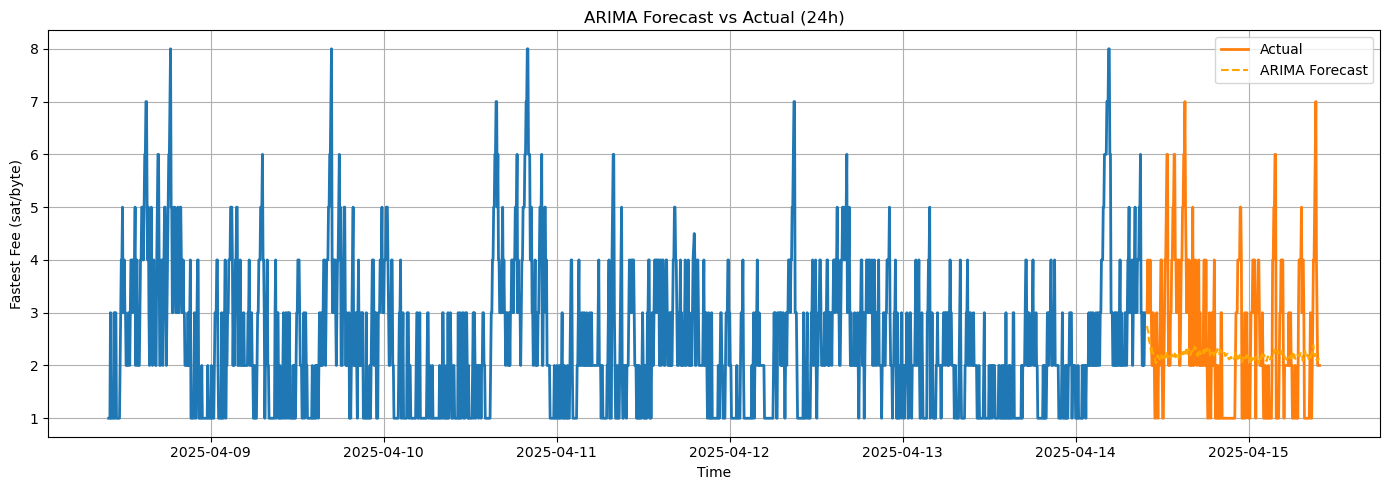

In [14]:

plt.figure(figsize=(14, 5))

# Plot actual values
plt.plot(y_train.index, y_train.values, linewidth=2)
plt.plot(y_test.index, y_test.values, label="Actual", linewidth=2)
# Plot predicted values
plt.plot(y_pred.index, y_pred.values, label="ARIMA Forecast", linestyle="--", color="orange")

plt.title("ARIMA Forecast vs Actual (24h)")
plt.xlabel("Time")
plt.ylabel("Fastest Fee (sat/byte)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
